# Bengio, et al's (2003) Neural Language Model - Caffe Implementation

In [1]:
import numpy as np
import caffe
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,8)

In [2]:
f = open('vc.csv','r')
voc = f.readlines()
f.close()
vocab = [None]*len(voc)
for n in range(len(voc)):
    vocab[n] = voc[n].split('\n')[0].replace(',', '').replace(' ','')

In [3]:
WordsInput = ['school','used','my'] # Priming words ['he','said','the'] ['she','had','a'] ['police','game','the']
IndexInput = [None]*len(WordsInput)
for i in range(len(WordsInput)):
    IndexInput[i] = vocab.index(WordsInput[i])+1

In [4]:
caffe.set_mode_cpu()

model_def = 'BengioLM_deploy.prototxt'
model_weights = 'BengioLM.caffemodel'

net = caffe.Net(model_def,model_weights,caffe.TEST)

In [5]:
for layer_name, blob in net.blobs.items():
    print (layer_name + '\t' + str(blob.data.shape))

data	(1, 3)
WordEmbedding	(1, 3, 50)
FC1	(1, 200)
predict	(1, 250)
probs	(1, 250)


In [6]:
for layer_name, param in net.params.items():
    print (layer_name + '\t' + str(param[0].data.shape) + str(param[1].data.shape))

WordEmbedding	(250, 50)(50,)
FC1	(200, 150)(200,)
predict	(250, 200)(250,)


In [7]:
net.blobs['data'].data[...] = IndexInput

In [8]:
out = net.forward()

In [9]:
pred_wrd = vocab[np.argmax(out['probs'])-1]
print("Predicted word:",pred_wrd)

Predicted word: life


In [10]:
print("Predicted 4-gram:",WordsInput[0],WordsInput[1],WordsInput[2],pred_wrd)

Predicted 4-gram: school used my life


### Using t-SNE to visualise the word embedding in a reduced feature space

In [11]:
weights = net.params['WordEmbedding'][0].data

In [12]:
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=5)
T = tsne.fit_transform(weights)

#### 2D visualisation

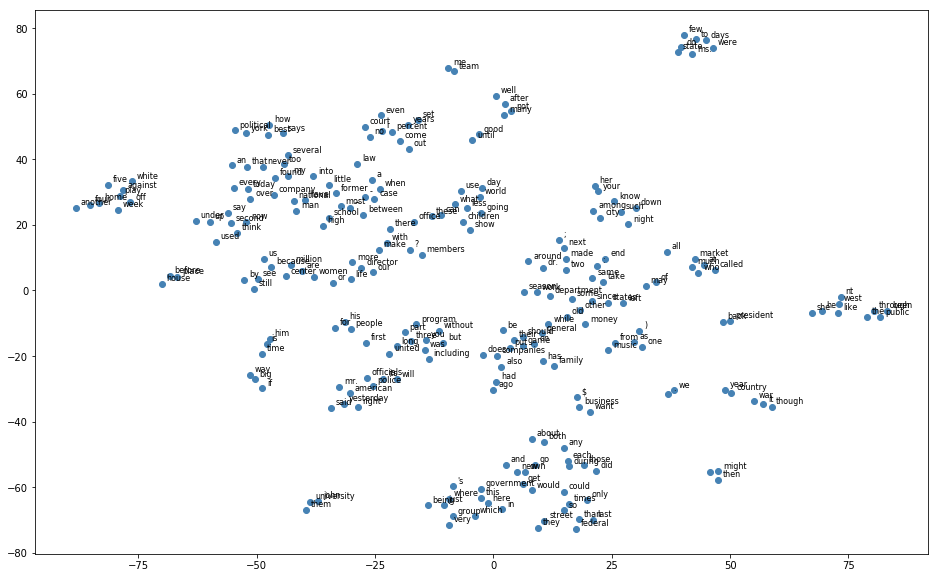

In [13]:
plt.figure(figsize=(16, 10))
plt.scatter(T[:, 0], T[:, 1], c='steelblue') 
for label, x, y in zip(vocab, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', size = 8)

In [14]:
tsne_3D = TSNE(n_components=3, random_state=0, n_iter=50000, perplexity=10, learning_rate = 100)
T_3D = tsne_3D.fit_transform(weights)

#### 3D visualisation

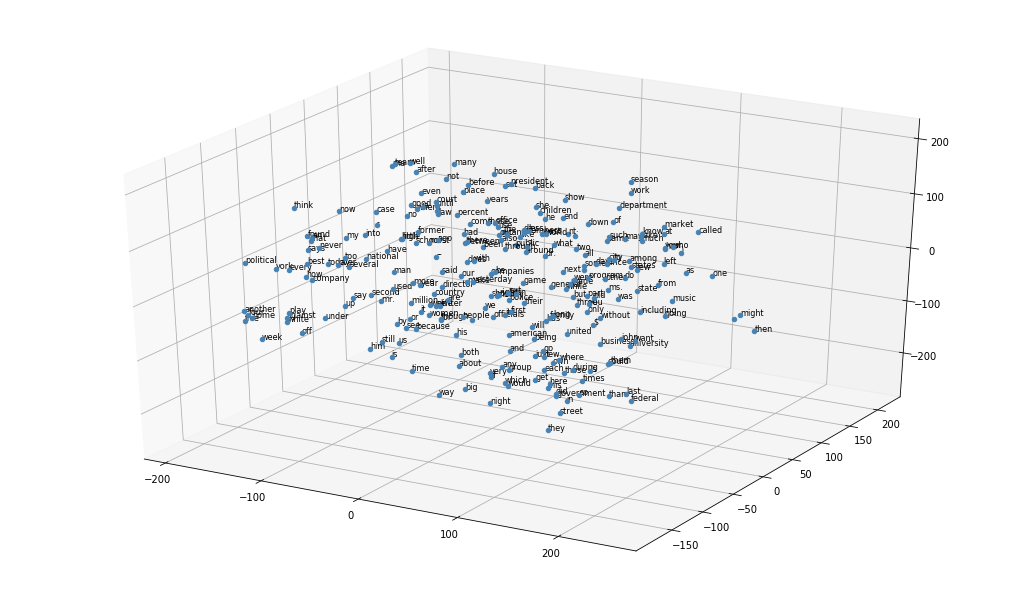

In [15]:
fig = plt.figure()
ax = Axes3D(fig)
for i in range(len(T_3D)):
    ax.scatter(T_3D[i, 0], T_3D[i, 1], T_3D[i, 2], color="steelblue")
    ax.text(T_3D[i, 0], T_3D[i, 1], T_3D[i, 2], '%s' % vocab[i], size = 8, color='k')

### Similarity of 3-grams in feature space (Euclidean distance)

In [16]:
def Euclidean(difference):
    x = np.sum(difference**2)**.5
    return x

In [17]:
Sent1 = ['he','used','my']
Sent2 = ['police','game','the']
Sent3 = ['she','used','a']
S1_Inp = [None]*len(Sent1)
S2_Inp = [None]*len(Sent2)
S3_Inp = [None]*len(Sent3)
for i in range(len(Sent1)):
    S1_Inp[i] = vocab.index(Sent1[i])+1
    S2_Inp[i] = vocab.index(Sent2[i])+1
    S3_Inp[i] = vocab.index(Sent3[i])+1

In [18]:
net.blobs['data'].data[...] = S1_Inp
net.forward()
S1 = np.asarray(list(net.blobs['WordEmbedding'].data))

In [19]:
net.blobs['data'].data[...] = S2_Inp
net.forward()
S2 = np.asarray(list(net.blobs['WordEmbedding'].data))

In [20]:
net.blobs['data'].data[...] = S3_Inp
net.forward()
S3 = np.asarray(list(net.blobs['WordEmbedding'].data))

In [21]:
print(Euclidean(S1 - S2), Euclidean(S1 - S3), Euclidean(S2 - S3))

3.4586734987435057 2.4893601981260978 3.9219795608260264


In [22]:
print("The 3-grams",Sent1,"and",Sent3,"are closest in feature space with a distance of %s units." % np.round(Euclidean(S1 - S3),2))

The 3-grams ['he', 'used', 'my'] and ['she', 'used', 'a'] are closest in feature space with a distance of 2.49 units.
